In [488]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread('./tents/train/images/image3.png')


In [489]:
import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil

In [490]:
# load images as NumPy arrays and append them to images list
images = []
for index, file in enumerate(glob.glob('./tents/train/images/*.png')):
    images.append(imageio.imread(file))
    
# how many images we have
print('We have {} images'.format(len(images)))

We have 4 images


In [491]:
# what are the sizes of the images
for index, file in enumerate(glob.glob('./tents/train/images/*.png')):
    print('Image {} have size of {}'.format(file[7:], images[index].shape))

Image /train/images/image7.png have size of (344, 600, 3)
Image /train/images/image5.png have size of (493, 600, 3)
Image /train/images/image1.png have size of (344, 600, 3)
Image /train/images/image3.png have size of (344, 600, 3)


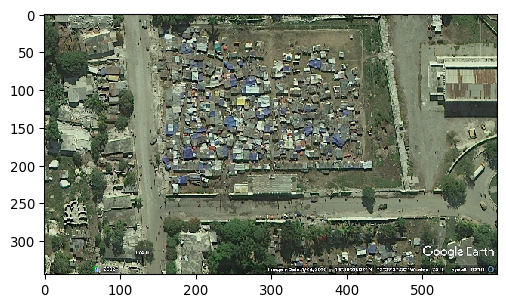

In [492]:
# Looking at the first image
ia.imshow(images[2])

Looking at the XML files.

In [493]:
# XML file names correspond to the image file names
for index, file in enumerate(glob.glob('./tents/train/annotations/*.xml')):
    print(file[1:])

/tents/train/annotations/image7.xml
/tents/train/annotations/image5.xml
/tents/train/annotations/image1.xml
/tents/train/annotations/image3.xml


1. Convert all XML files into one CSV file that we can feed into TensorFlow Object Detection API


In [494]:
# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [495]:
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv('./tents/train/annotations/')
labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [496]:
# let's see what's inside
# each bounding box has a separate row
labels_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image7.png,2358,1350,tent,998,433,1050,479
1,image7.png,2358,1350,tent,879,136,926,204
2,image7.png,2358,1350,tent,929,153,958,188
3,image7.png,2358,1350,tent,707,144,798,205
4,image7.png,2358,1350,tent,715,683,785,753
...,...,...,...,...,...,...,...,...
210,image3.png,2358,1350,not_tent,1009,794,1113,893
211,image3.png,2358,1350,not_tent,894,815,1002,885
212,image3.png,2358,1350,not_tent,1393,676,1620,821
213,image3.png,2358,1350,not_tent,1463,916,1545,994


2. Resize all images together with the corresponding object bounding boxes

In [497]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename')

In [498]:
group_df1 = grouped.get_group('image1.png')
group_df1 = group_df1.reset_index()
group_df1 = group_df1.drop(['index'], axis=1)
group_df1

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image1.png,1736,1426,tent,459,793,491,827
1,image1.png,1736,1426,tent,158,221,190,250
2,image1.png,1736,1426,tent,413,732,441,758
3,image1.png,1736,1426,tent,676,527,699,554
4,image1.png,1736,1426,tent,765,517,790,540
...,...,...,...,...,...,...,...,...
74,image1.png,1736,1426,not_tent,1270,1018,1373,1163
75,image1.png,1736,1426,not_tent,1153,1133,1228,1189
76,image1.png,1736,1426,not_tent,1499,696,1586,903
77,image1.png,1736,1426,not_tent,1129,1253,1224,1370


In [499]:
group_df2 = grouped.get_group('image3.png')
group_df2 = group_df2.reset_index()
group_df2 = group_df2.drop(['index'], axis=1)
group_df2

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image3.png,2358,1350,tent,1012,404,1056,436
1,image3.png,2358,1350,tent,1125,390,1184,429
2,image3.png,2358,1350,tent,1125,436,1154,474
3,image3.png,2358,1350,tent,1013,492,1047,516
4,image3.png,2358,1350,tent,1188,505,1232,555
5,image3.png,2358,1350,tent,1072,559,1124,614
6,image3.png,2358,1350,tent,1143,588,1191,623
7,image3.png,2358,1350,tent,1271,562,1315,623
8,image3.png,2358,1350,tent,1152,682,1172,707
9,image3.png,2358,1350,tent,1170,681,1197,709


Visualization of bounding boxes.

In [500]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array_1 = group_df1.drop(['filename', 'width', 'height', 'class'], axis=1).values

# display the array we've got
bb_array_1.shape

(79, 4)

In [501]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array_2 = group_df2.drop(['filename', 'width', 'height', 'class'], axis=1).values

# display the array we've got
bb_array_2.shape

(42, 4)

In [502]:
# pass the array of bounding boxes coordinates to the imgaug library
bbs1 = BoundingBoxesOnImage.from_xyxy_array(bb_array_1, 
                                           shape=images[0].shape)


In [503]:
# pass the array of bounding boxes coordinates to the imgaug library
bbs2 = BoundingBoxesOnImage.from_xyxy_array(bb_array_2, 
                                           shape=images[1].shape)


In [504]:
bbs1[0]

BoundingBox(x1=459.0000, y1=793.0000, x2=491.0000, y2=827.0000, label=None)

In [505]:
bbs2[0]

BoundingBox(x1=1012.0000, y1=404.0000, x2=1056.0000, y2=436.0000, label=None)

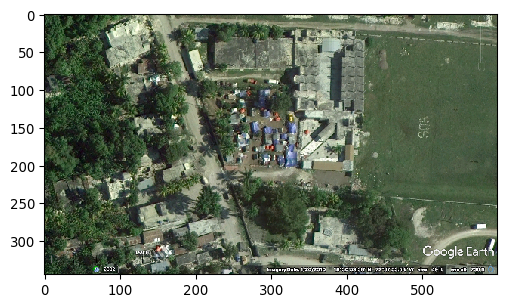

In [506]:
# display the image and draw bounding boxes
ia.imshow(bbs1[3].draw_on_image(images[0], size = 2))

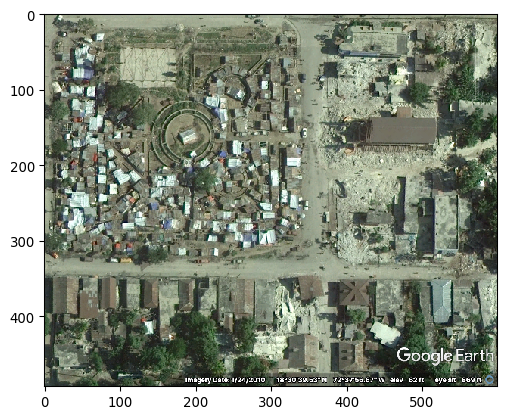

In [507]:
# display the image and draw bounding boxes
ia.imshow(bbs2[10].draw_on_image(images[1], size = 2))

In [508]:
# to resize the images we create two augmenters
# one is used when the image height is more than 600px and the other when the width is more than 600px
height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 600, "width": 'keep-aspect-ratio'})
])

width_resize = iaa.Sequential([ 
    iaa.Resize({"height": 'keep-aspect-ratio', "width": 600})
])

In [509]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [510]:
bbs_obj_to_df(bbs1)

,xmin,ymin,xmax,ymax
0,459.0,793.0,491.0,827.0
1,158.0,221.0,190.0,250.0
2,413.0,732.0,441.0,758.0
3,676.0,527.0,699.0,554.0
4,765.0,517.0,790.0,540.0
...,...,...,...,...
74,1270.0,1018.0,1373.0,1163.0
75,1153.0,1133.0,1228.0,1189.0
76,1499.0,696.0,1586.0,903.0
77,1129.0,1253.0,1224.0,1370.0


In [511]:
bbs_obj_to_df(bbs2)

,xmin,ymin,xmax,ymax
0,1012.0,404.0,1056.0,436.0
1,1125.0,390.0,1184.0,429.0
2,1125.0,436.0,1154.0,474.0
3,1013.0,492.0,1047.0,516.0
4,1188.0,505.0,1232.0,555.0
5,1072.0,559.0,1124.0,614.0
6,1143.0,588.0,1191.0,623.0
7,1271.0,562.0,1315.0,623.0
8,1152.0,682.0,1172.0,707.0
9,1170.0,681.0,1197.0,709.0


In [512]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    
    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   The only difference between if and elif statements below is the use of height_resize and width_resize augmentors
    #   deffined previously.

    #   If image height is greater than or equal to image width 
    #   AND greater than 600px perform resizing augmentation shrinking image height to 600px.
        if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    #   if image width is greater than image height 
    #   AND greater than 600px perform resizing augmentation shrinking image width to 600px
        elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 600px 
        else:
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [513]:
# apply resizing augmentation to our images and write the updated images and bounding boxes annotations to the DataFrame 
# we will not apply prefix to our files and will overwrite images in the same directory
resized_images_df = resize_imgaug(labels_df, './tents/train/images/', './tents/train/images/', '')



In [514]:
# display new DataFrame
resized_images_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image7.png,600,344,tent,998.0,433.0,1050.0,479.0
1,image7.png,600,344,tent,879.0,136.0,926.0,204.0
2,image7.png,600,344,tent,929.0,153.0,958.0,188.0
3,image7.png,600,344,tent,707.0,144.0,798.0,205.0
4,image7.png,600,344,tent,715.0,683.0,785.0,753.0
...,...,...,...,...,...,...,...,...
210,image3.png,600,344,not_tent,1009.0,794.0,1113.0,893.0
211,image3.png,600,344,not_tent,894.0,815.0,1002.0,885.0
212,image3.png,600,344,not_tent,1393.0,676.0,1620.0,821.0
213,image3.png,600,344,not_tent,1463.0,916.0,1545.0,994.0


In [515]:
# overwrite the labels.csv with updated info
resized_images_df.to_csv('labels_resized.csv', index=False)

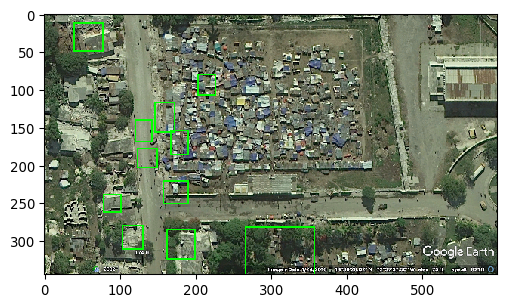

In [516]:
# visualise the resized image with bounding boxes
# to make sure our bounding boxes were resized correctly as well
grouped = resized_images_df.groupby('filename')
group_df = grouped.get_group('image1.png')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread('./tents/train/images/image1.png')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=2))

In [517]:
# This setup of augmentation parameters will pick two of four given augmenters and apply them in random order
aug = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(rotate=(-60, 60)),
    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [518]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [519]:
# Apply augmentation to our images and save files into 'aug_images/' folder with 'aug1_' prefix.
# Write the updated images and bounding boxes annotations to the augmented_images_df dataframe.
augmented_images_df = image_aug(resized_images_df, './tents/train/images/', './tents/train/images/aug_images', 'aug1_', aug)


In [520]:
# display new dataframe
augmented_images_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,aug1_image7.png,600,344,tent,569.788147,0.000000,600.000000,24.550011
1,aug1_image7.png,600,344,tent,114.594093,59.702587,411.187988,244.287857
2,aug1_image7.png,600,344,tent,326.516968,301.163635,469.696289,344.000000
3,aug1_image7.png,600,344,tent,140.933014,0.000000,289.423340,68.681465
4,aug1_image7.png,600,344,tent,532.879822,49.730530,599.573425,144.426254
...,...,...,...,...,...,...,...,...
210,aug1_image3.png,600,344,not_tent,NaN,NaN,NaN,NaN
211,aug1_image3.png,600,344,not_tent,NaN,NaN,NaN,NaN
212,aug1_image3.png,600,344,not_tent,NaN,NaN,NaN,NaN
213,aug1_image3.png,600,344,not_tent,NaN,NaN,NaN,NaN


In [521]:
augmented_images_df.shape

(215, 8)

In [522]:
augmented_images_df.isnull().sum()

filename      0
width         0
height        0
class         0
xmin        193
ymin        193
xmax        193
ymax        193
dtype: int64

In [523]:
grouped_resized = resized_images_df.groupby('filename')
grouped_augmented = augmented_images_df.groupby('filename')

for filename in resized_images_df['filename'].unique():    
    
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    resized_img = imageio.imread('./tents/train/images/'+filename)
    bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    
    group_a_df = grouped_augmented.get_group('aug1_'+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    augmented_img = imageio.imread('./tents/train/images/aug_images/'+'aug1_'+filename)
    bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    
    ia.imshow(np.hstack([
            bbs_r.draw_on_image(resized_img, size=2),
            bbs_a.draw_on_image(augmented_img, size=2)
            ]))

ValueError: cannot convert float NaN to integer

In [524]:
# Concat resized_images_df and augmented_images_df together and save in a new all_labels.csv file
all_labels_df = pd.concat([resized_images_df, augmented_images_df])
all_labels_df.to_csv('all_labels.csv', index=False)

In [525]:
# Lastly we can copy all our augmented images in the same folder as original resized images
for file in os.listdir('./tents/train/images/aug_images'):
    shutil.copy('./tents/train/images/aug_images'+file, './tents/train/images'+file)
    

FileNotFoundError: [Errno 2] No such file or directory: './tents/train/images/aug_images.DS_Store'